In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [4]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits
    
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    # print(model)
    return model

# Instantiate the model
vgg_model = VGG16BinaryClassifier(pretrained=True)
print(vgg_model)

c:\Users\micah\anaconda3\envs\clinical_ai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micah\anaconda3\envs\clinical_ai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16BinaryClassifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

### Load 'best_VGG_model_1' from github

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_path = "best_VGG_model_1.pth"
model = load_model(model_path, device)

### Set dataset directory

In [91]:
# Transform (adjust if model trained on grayscale or normalized differently)
transform = transforms.Compose([
    transforms.Resize((1024, 512)),  # keep the original shape
    transforms.ToTensor(),
])

# Get list of first 3 image paths
image_folder = 'dataset/fovea_yes'
image_paths = sorted(os.listdir(image_folder))[:3]  # sort to get consistent order
print(image_paths)

['2002000001_20240311_132300_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg', '2002000001_20240311_132300_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_072.jpg', '2002000002_20240311_132300_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg']


### Create saliency maps

In [90]:
saliency_maps = []

for i, filename in enumerate(image_paths):
    img_path = os.path.join(image_folder, filename)
    image = Image.open(img_path).convert('RGB')  # use 'L' if grayscale
    
    # we create an input tensor in order to store the gradients associated with it
    # the idea behind creating a heatmap is basically just finding the gradient
    # of the prediction with respect to each individual pixel
    # towards this end, we must ensure that the gradients are required for 
    # the input tensor, as these gradients will implictly store the heatmap information.
    input_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, 1024, 512]
    input_tensor.requires_grad_()

    output = model(input_tensor)

    ### NOTE: we no longer want round to a pure number. We want to make sure that we don't kill the gradients with round() or int().
    class_score = torch.sigmoid(output)[0, 0]  # or just output[0, 0] if using BCEWithLogitsLoss
    class_score.backward()

    # Saliency = max absolute gradient across channels
    # with just this single line, we can find the saliency, as the 
    # heatmap is implicitly stored in the gradient with respect to the input tensor
    saliency = input_tensor.grad.data.abs().squeeze().detach().numpy()
    saliency = np.max(saliency, axis=0)
    saliency_maps.append((image, saliency))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\micah\\OneDrive\\Gmail OneDrive\\Desktop\\CMU\\_Spring 2025\\Projects in BME\\Fovea Detection\\processed_volumes\\1017\\left\\2002000001_20240311_132300_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg'

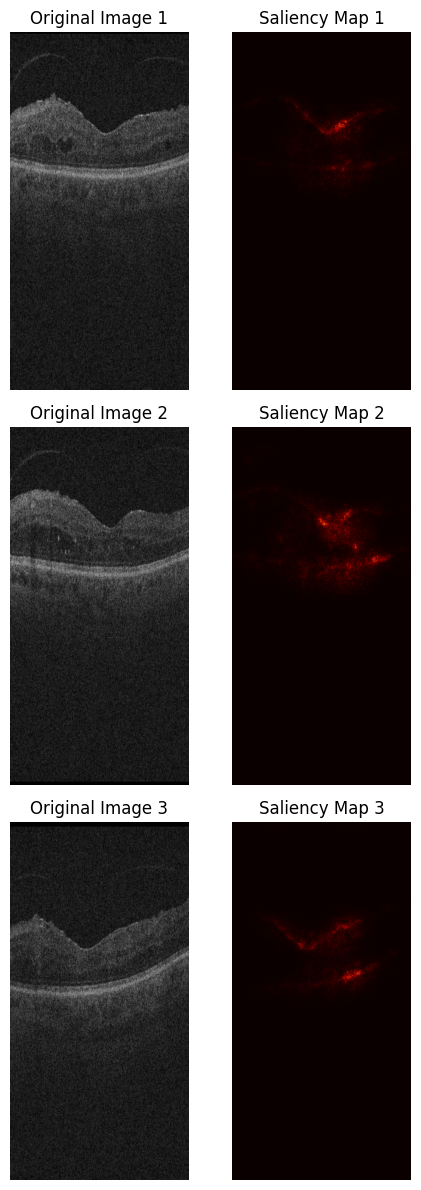

In [86]:
fig, axes = plt.subplots(3, 2, figsize=(5, 12))

for i, (image, saliency) in enumerate(saliency_maps):
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(saliency, cmap='hot')
    axes[i, 1].set_title(f"Saliency Map {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


### Create binary masks from saliency maps

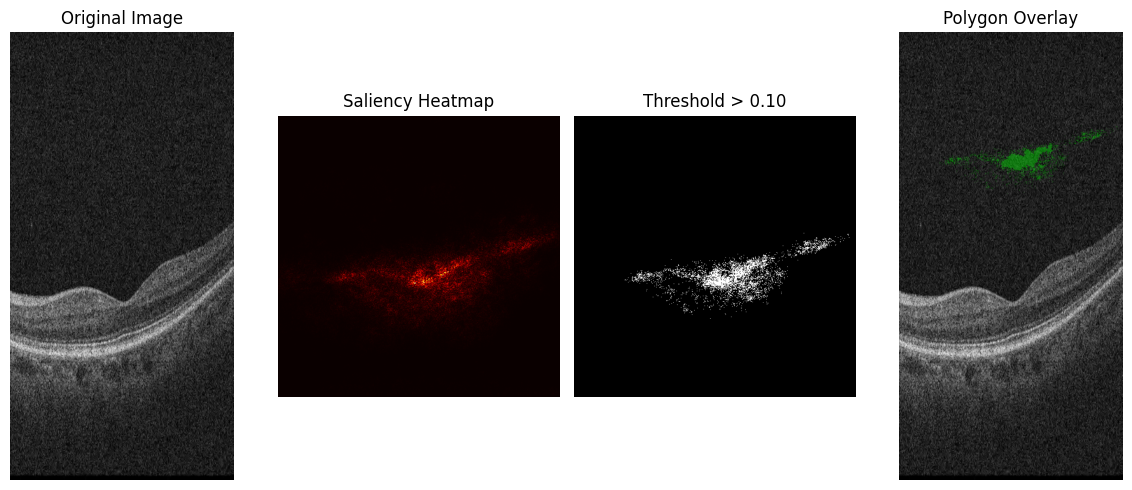

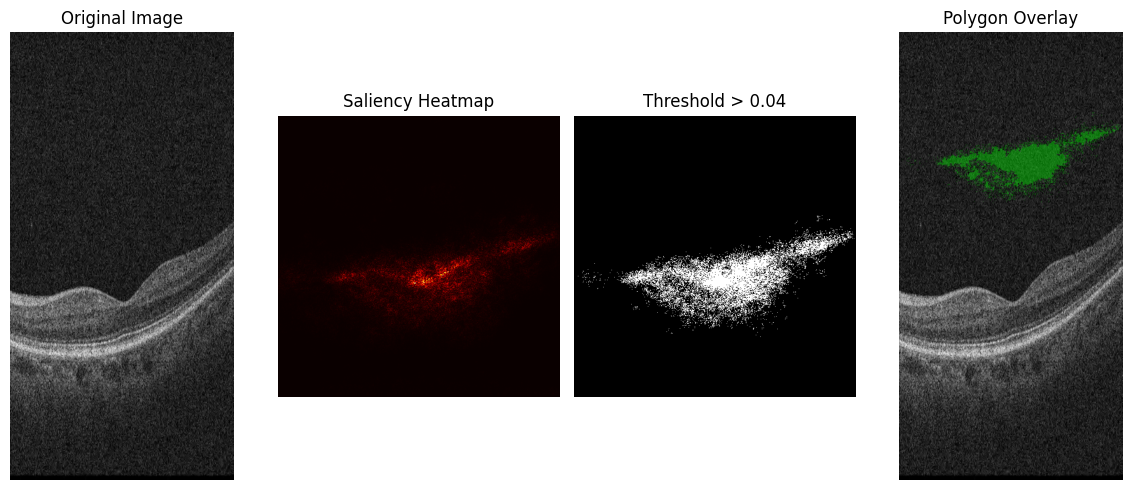

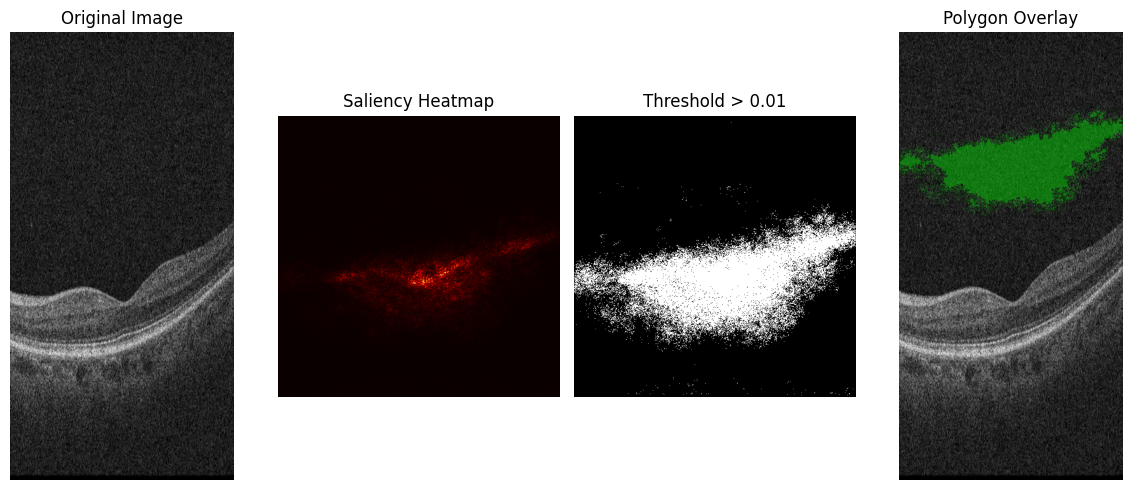

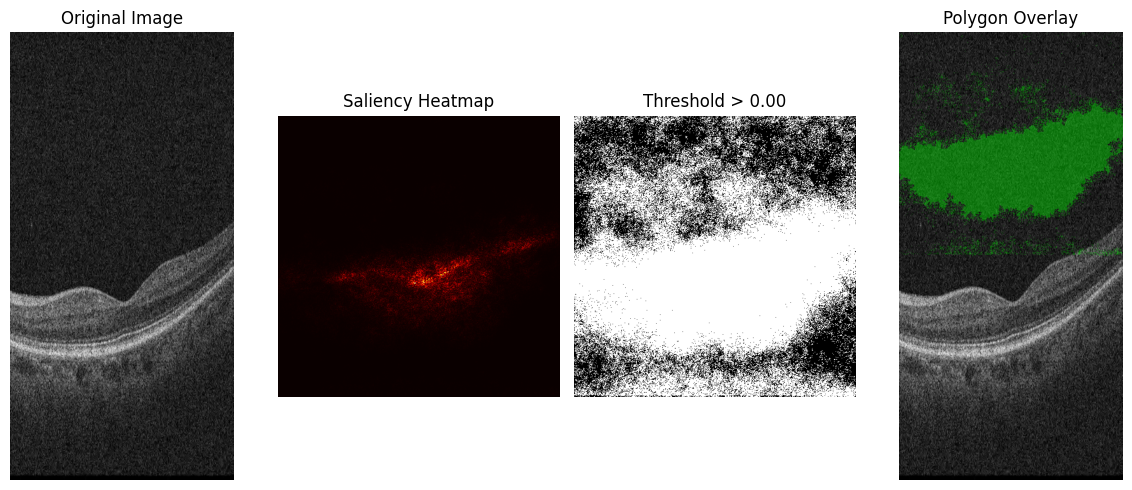

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

def visualize_saliency_polygons(image_pil, saliency, threshold_ratio=0.5, alpha=0.4):
    """
    image_pil: original PIL image
    saliency: numpy array (H, W), raw saliency map
    threshold_ratio: float between 0 and 1 to threshold saliency
    alpha: transparency of the polygon overlay
    """

    # Normalize saliency
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    threshold_val = threshold_ratio * saliency_norm.max()
    binary_mask = saliency_norm > threshold_val

    # Convert to 8-bit
    saliency_8bit = (255 * saliency_norm).astype(np.uint8)
    _, binary_8bit = cv2.threshold(saliency_8bit, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)

    # Find contours (polygons)
    contours, _ = cv2.findContours(binary_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert image for drawing
    image_rgb = np.array(image_pil.convert("RGB"))
    overlay = image_rgb.copy()

    # Draw filled polygons (contours)
    cv2.drawContours(overlay, contours, -1, color=(0, 255, 0), thickness=cv2.FILLED)

    # Blend overlay with original image
    blended = cv2.addWeighted(overlay, alpha, image_rgb, 1 - alpha, 0)

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))

    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(saliency_norm, cmap='hot')
    axes[1].set_title("Saliency Heatmap")
    axes[1].axis("off")

    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f"Threshold > {threshold_ratio:.2f}")
    axes[2].axis("off")

    axes[3].imshow(blended)
    axes[3].set_title("Polygon Overlay")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

    return binary_mask, contours

binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.1)
binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.04)
binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.01)
binary_mask, polygon_contours = visualize_saliency_polygons(image, saliency, threshold_ratio=0.001)


### Having a super low threshold seems to cast a very wide net for every individual b-scan. This is good. We like that.
#### We can cast a wide net for every individual B-scan to facilitate the IoU analysis

Setting threshold_ratio to 0.04. I find that 0.001 and 0.01 is way too small (leading to a huge mask), making the intersection less meaningful.

In [107]:
threshold_ratio = 0.04

In [124]:
import os
import numpy as np
import torch
import cv2
from PIL import Image
from torchvision import transforms

# === Model (make sure yours is loaded properly) ===
model.eval()

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((1024, 512)),  # keep the original shape
    transforms.ToTensor(),
])

# === Visualizer ===
def visualize_saliency_polygons(image_pil, saliency, threshold_ratio, alpha=0.4):
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    threshold_val = threshold_ratio * saliency_norm.max()
    binary_mask = saliency_norm > threshold_val

    saliency_8bit = (255 * saliency_norm).astype(np.uint8)
    _, binary_8bit = cv2.threshold(saliency_8bit, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_rgb = np.array(image_pil.convert("RGB"))
    overlay = image_rgb.copy()
    cv2.drawContours(overlay, contours, -1, color=(0, 255, 0), thickness=cv2.FILLED)
    blended = cv2.addWeighted(overlay, alpha, image_rgb, 1 - alpha, 0)

    return binary_mask.astype(np.uint8), contours, blended

# === Main Paths ===
predictions_root = "predictions"
output_root = "generated_heatmaps"
os.makedirs(output_root, exist_ok=True)

volume_folders = sorted([f for f in os.listdir(predictions_root) if os.path.isdir(os.path.join(predictions_root, f))])

# === Main Loop ===
for volume in volume_folders:
    fovea_input_dir = os.path.join(predictions_root, volume, "predictions", "fovea")
    if not os.path.exists(fovea_input_dir):
        print(f"⚠️ Skipping {volume}: no fovea folder found.")
        continue

    saliency_out_dir = os.path.join(output_root, volume, "saliency_maps")
    heatmaps_out_dir = os.path.join(output_root, volume, "heatmaps")

    # Skip this volume if both output folders already exist and are non-empty
    if os.path.isdir(saliency_out_dir) and os.listdir(saliency_out_dir) and \
       os.path.isdir(heatmaps_out_dir) and os.listdir(heatmaps_out_dir):
        print(f"✅ Skipping {volume}: already processed.")
        continue

    os.makedirs(saliency_out_dir, exist_ok=True)
    os.makedirs(heatmaps_out_dir, exist_ok=True)

    for filename in sorted(os.listdir(fovea_input_dir)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img_path = os.path.join(fovea_input_dir, filename)
        image = Image.open(img_path).convert('RGB')

        # === Saliency Map Generation ===
        input_tensor = transform(image).unsqueeze(0)
        input_tensor.requires_grad_()
        output = model(input_tensor)

        class_score = torch.sigmoid(output)[0, 0]
        class_score.backward()

        saliency = input_tensor.grad.data.abs().squeeze().detach().numpy()
        saliency = np.max(saliency, axis=0)

        # Save saliency map
        saliency_filename = filename.replace('.png', '_saliency.npy')
        saliency_path = os.path.join(saliency_out_dir, saliency_filename)
        np.save(saliency_path, saliency)

        # === Polygon-based Heatmap ===
        binary_mask, contours, overlay = visualize_saliency_polygons(image, saliency, threshold_ratio=0.001)

        base_name = filename.replace('.png', '')
        mask_path = os.path.join(heatmaps_out_dir, f"{base_name}_mask.png")
        contour_path = os.path.join(heatmaps_out_dir, f"{base_name}_contours.npy")
        overlay_path = os.path.join(heatmaps_out_dir, f"{base_name}_overlay.png")

        cv2.imwrite(mask_path, (binary_mask * 255).astype(np.uint8))
        np.save(contour_path, np.array(contours, dtype=object), allow_pickle=True)
        cv2.imwrite(overlay_path, overlay)

    print(f"✅ Processed {volume}")

print("🎉 All saliency maps and heatmaps generated (or skipped) successfully.")


✅ Skipping 1002_left: already processed.
✅ Skipping 1002_right: already processed.
✅ Skipping 1003_left: already processed.
✅ Skipping 1003_right: already processed.
✅ Skipping 1004_left: already processed.
✅ Skipping 1004_right: already processed.
✅ Skipping 1005_left: already processed.
✅ Skipping 1005_right: already processed.
✅ Skipping 1006_left: already processed.
✅ Skipping 1006_right: already processed.
✅ Skipping 1007_left: already processed.
✅ Skipping 1007_right: already processed.
✅ Skipping 1008_left: already processed.
✅ Skipping 1008_right: already processed.
✅ Skipping 1009_left: already processed.
✅ Skipping 1009_right: already processed.
✅ Skipping 1010_right: already processed.
✅ Skipping 1011_left: already processed.
✅ Skipping 1011_right: already processed.
✅ Skipping 1012_left: already processed.
✅ Skipping 1012_right: already processed.
✅ Skipping 1013_left: already processed.
✅ Skipping 1013_right: already processed.
✅ Skipping 1014_left: already processed.
✅ Sk

# Intersection of Unions
##### Note: the intersection mask is pretty large, but I don't think that's necessarily a bad thing. Our goal is to ensure we are encapsulating the fovea, and the mask accomplishes that at minimum.

In [125]:
import os
import cv2
import numpy as np

def load_and_threshold_saliency(saliency_path, threshold_ratio=0.001):
    saliency = np.load(saliency_path)
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    threshold = threshold_ratio * saliency_norm.max()
    binary_mask = (saliency_norm > threshold).astype(np.uint8)
    return binary_mask, saliency_norm

generated_root = 'generated_heatmaps'
volume_folders = sorted([f for f in os.listdir(generated_root) if os.path.isdir(os.path.join(generated_root, f))])

for volume in volume_folders:
    saliency_dir = os.path.join(generated_root, volume, "saliency_maps")
    iou_dir = os.path.join(generated_root, volume, "IoU")
    os.makedirs(iou_dir, exist_ok=True)

    saliency_files = sorted([f for f in os.listdir(saliency_dir) if f.endswith('.npy')])
    masks = []
    saliency_images = []

    for f in saliency_files:
        saliency_path = os.path.join(saliency_dir, f)
        try:
            binary_mask, saliency_norm = load_and_threshold_saliency(saliency_path)
            masks.append(binary_mask)
            saliency_images.append(saliency_norm)
        except Exception as e:
            print(f"⚠️ Failed to process {saliency_path}: {e}")

    if len(masks) == 0 or len(saliency_images) == 0:
        print(f"❌ No valid masks or saliency maps found in {volume}. Skipping IoU.")
        continue

    base_shape = masks[0].shape
    resized_masks = [cv2.resize(m, (base_shape[1], base_shape[0]), interpolation=cv2.INTER_NEAREST) for m in masks]
    resized_saliencies = [cv2.resize(s, (base_shape[1], base_shape[0]), interpolation=cv2.INTER_AREA) for s in saliency_images]

    masks_stack = np.stack(resized_masks)
    intersection = np.sum(masks_stack, axis=0) == len(masks_stack)
    iou_mask = (intersection * 255).astype(np.uint8)

    cv2.imwrite(os.path.join(iou_dir, "iou_mask.png"), iou_mask)

    # Compute average saliency image
    image_avg = np.mean(resized_saliencies, axis=0)
    image_avg = (255 * image_avg).astype(np.uint8)
    image_rgb = cv2.cvtColor(image_avg, cv2.COLOR_GRAY2BGR)

    coords = np.argwhere(intersection)
    if coords.size > 0:
        cy, cx = np.mean(coords, axis=0).astype(int)
        cv2.drawMarker(image_rgb, (cx, cy), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)
    else:
        print(f"⚠️ No intersecting region found for {volume}")

    cv2.imwrite(os.path.join(iou_dir, "center_marked.png"), image_rgb)

print("✅ Intersection masks and center visualizations completed.")


❌ No valid masks or saliency maps found in 1022_left. Skipping IoU.
❌ No valid masks or saliency maps found in Test_40002739_20211013_113000_L_OCT. Skipping IoU.
✅ Intersection masks and center visualizations completed.


## EXTRA: produce visualization of 1002_left #60 for paper figure

In [106]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import torch.nn as nn

# ============================
# MODEL DEFINITION (match your training architecture)
# ============================
class VGGFoveaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 256 * 128, 128),  # Adjust if your input size differs
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ============================
# LOAD MODEL
# ============================
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_path = "best_VGG_model_1.pth"

model = VGGFoveaClassifier().to(device)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

# ============================
# TRANSFORM & IMAGE SETUP
# ============================
transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.ToTensor(),
])

image_folder = 'dataset/fovea_yes'
target_filename = "1017_left_bscan_061.png"
image_path = os.path.join(image_folder, target_filename)
image = Image.open(image_path).convert('RGB')

# ============================
# SALIENCY CALCULATION
# ============================
input_tensor = transform(image).unsqueeze(0).to(device)
input_tensor.requires_grad_()

output = model(input_tensor)
class_score = torch.sigmoid(output)[0, 0]
class_score.backward()

saliency = input_tensor.grad.abs().squeeze().detach().cpu().numpy()
saliency = np.max(saliency, axis=0)

# ============================
# VISUALIZATION FUNCTION
# ============================
def visualize_saliency_polygons(image_pil, saliency, threshold_ratio=0.5, alpha=0.4):
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    saliency_8bit = (255 * saliency_norm).astype(np.uint8)
    _, binary_8bit = cv2.threshold(saliency_8bit, int(threshold_ratio * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_rgb = np.array(image_pil.convert("RGB"))
    overlay = image_rgb.copy()
    cv2.drawContours(overlay, contours, -1, color=(0, 255, 0), thickness=cv2.FILLED)
    blended = cv2.addWeighted(overlay, alpha, image_rgb, 1 - alpha, 0)

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(saliency_norm, cmap='hot')
    axes[1].set_title("Saliency Heatmap")
    axes[1].axis("off")

    axes[2].imshow(binary_8bit, cmap='gray')
    axes[2].set_title(f"Threshold > {threshold_ratio:.2f}")
    axes[2].axis("off")

    axes[3].imshow(blended)
    axes[3].set_title("Polygon Overlay")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

    return binary_8bit, contours

# ============================
# PLOT
# ============================
for threshold in [0.1, 0.04, 0.01, 0.001]:
    visualize_saliency_polygons(image, saliency, threshold_ratio=threshold)


RuntimeError: Error(s) in loading state_dict for VGGFoveaClassifier:
	Missing key(s) in state_dict: "features.0.weight", "features.0.bias", "features.3.weight", "features.3.bias", "classifier.1.weight", "classifier.1.bias", "classifier.3.weight", "classifier.3.bias". 
	Unexpected key(s) in state_dict: "vgg16.features.0.weight", "vgg16.features.0.bias", "vgg16.features.2.weight", "vgg16.features.2.bias", "vgg16.features.5.weight", "vgg16.features.5.bias", "vgg16.features.7.weight", "vgg16.features.7.bias", "vgg16.features.10.weight", "vgg16.features.10.bias", "vgg16.features.12.weight", "vgg16.features.12.bias", "vgg16.features.14.weight", "vgg16.features.14.bias", "vgg16.features.17.weight", "vgg16.features.17.bias", "vgg16.features.19.weight", "vgg16.features.19.bias", "vgg16.features.21.weight", "vgg16.features.21.bias", "vgg16.features.24.weight", "vgg16.features.24.bias", "vgg16.features.26.weight", "vgg16.features.26.bias", "vgg16.features.28.weight", "vgg16.features.28.bias", "vgg16.classifier.0.weight", "vgg16.classifier.0.bias", "vgg16.classifier.3.weight", "vgg16.classifier.3.bias", "vgg16.classifier.6.weight", "vgg16.classifier.6.bias". 

## INFERNO Vanilla Saliency

In [32]:
def visualize_inferno_saliency(image_pil, saliency, output_path="vanilla_heatmap_inferno.png", alpha=0.5):
    # Normalize saliency
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    saliency_uint8 = np.uint8(255 * saliency_norm)

    # Apply Inferno colormap
    heatmap = cv2.applyColorMap(saliency_uint8, cv2.COLORMAP_INFERNO)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, image_pil.size)

    # Original image
    image_rgb = np.array(image_pil.convert("RGB"))

    # Blend image with heatmap
    blended = cv2.addWeighted(image_rgb, 1 - alpha, heatmap, alpha, 0)

    # Display with no padding
    fig = plt.figure(frameon=False)
    fig.set_size_inches(blended.shape[1] / 100, blended.shape[0] / 100)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(blended)
    plt.show()

    # Save result
    plt.imsave(output_path, blended)
    print(f"✅ Inferno saliency heatmap saved to: {output_path}")

    


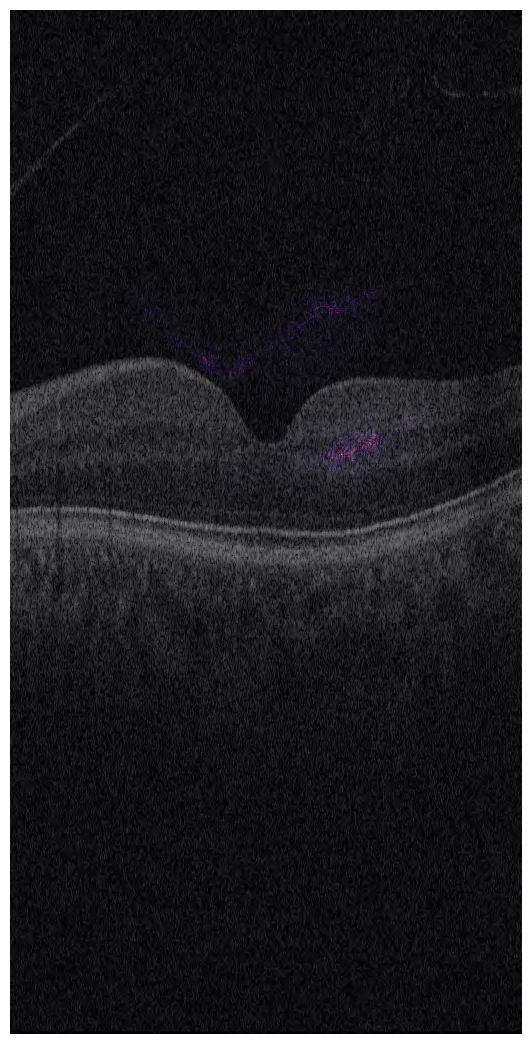

✅ Inferno saliency heatmap saved to: vanilla_heatmap_inferno.png


In [17]:
# Load image
image_path = r"C:\Users\micah\OneDrive\Gmail OneDrive\Desktop\CMU\_Spring 2025\Projects in BME\Fovea Detection\processed_volumes\1002\left\1002_left_bscan_060.png"
image = Image.open(image_path)

# Create or load a saliency map
# Example dummy map: saliency = np.random.rand(image.size[1], image.size[0])
# Replace this with your true vanilla saliency map
# saliency = your_computed_input_gradient.abs().squeeze().cpu().numpy()
# Be sure it matches shape (H, W)

visualize_inferno_saliency(image, saliency)


In [1]:
def visualize_boosted_saliency(image_pil, saliency, output_path="vanilla_boosted.png", boost=10, alpha=0.5):
    boosted = saliency * boost
    norm = (boosted - boosted.min()) / (boosted.max() - boosted.min() + 1e-8)
    norm = np.clip(norm, 0, 1)
    
    heatmap = cv2.applyColorMap(np.uint8(255 * norm), cv2.COLORMAP_INFERNO)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, image_pil.size)

    image_np = np.array(image_pil.convert("RGB"))
    blended = cv2.addWeighted(image_np, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(blended)
    plt.axis('off')
    plt.title("Boosted Saliency Overlay")
    plt.tight_layout()
    plt.savefig(output_path, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"✅ Boosted saliency saved to: {output_path}")


In [30]:
visualize_boosted_saliency(
    image_pil=image,           # your original PIL image
    saliency=saliency,         # your raw saliency map (ideally abs(grad))
    output_path="vanilla_boosted.png",  # output file
    boost=500,                  # boost factor (try 10, 20, 50)
    alpha=0.5                  # blending transparency
)


✅ Boosted saliency saved to: vanilla_boosted.png


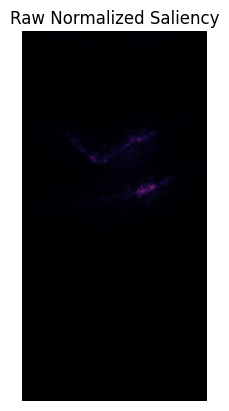

In [20]:
saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
plt.imshow(saliency_norm, cmap='inferno')
plt.title("Raw Normalized Saliency")
plt.axis('off')
plt.show()


## GRAD-CAM VISUALIZATION

Model output: -1.1940
Activations shape: torch.Size([1, 512, 16, 32])
Gradients shape: torch.Size([1, 512, 16, 32])
Gradients mean: -0.00012907575001008809

Attempting with target layer 0

Attempting with target layer 1
Valid CAM found with layer 1


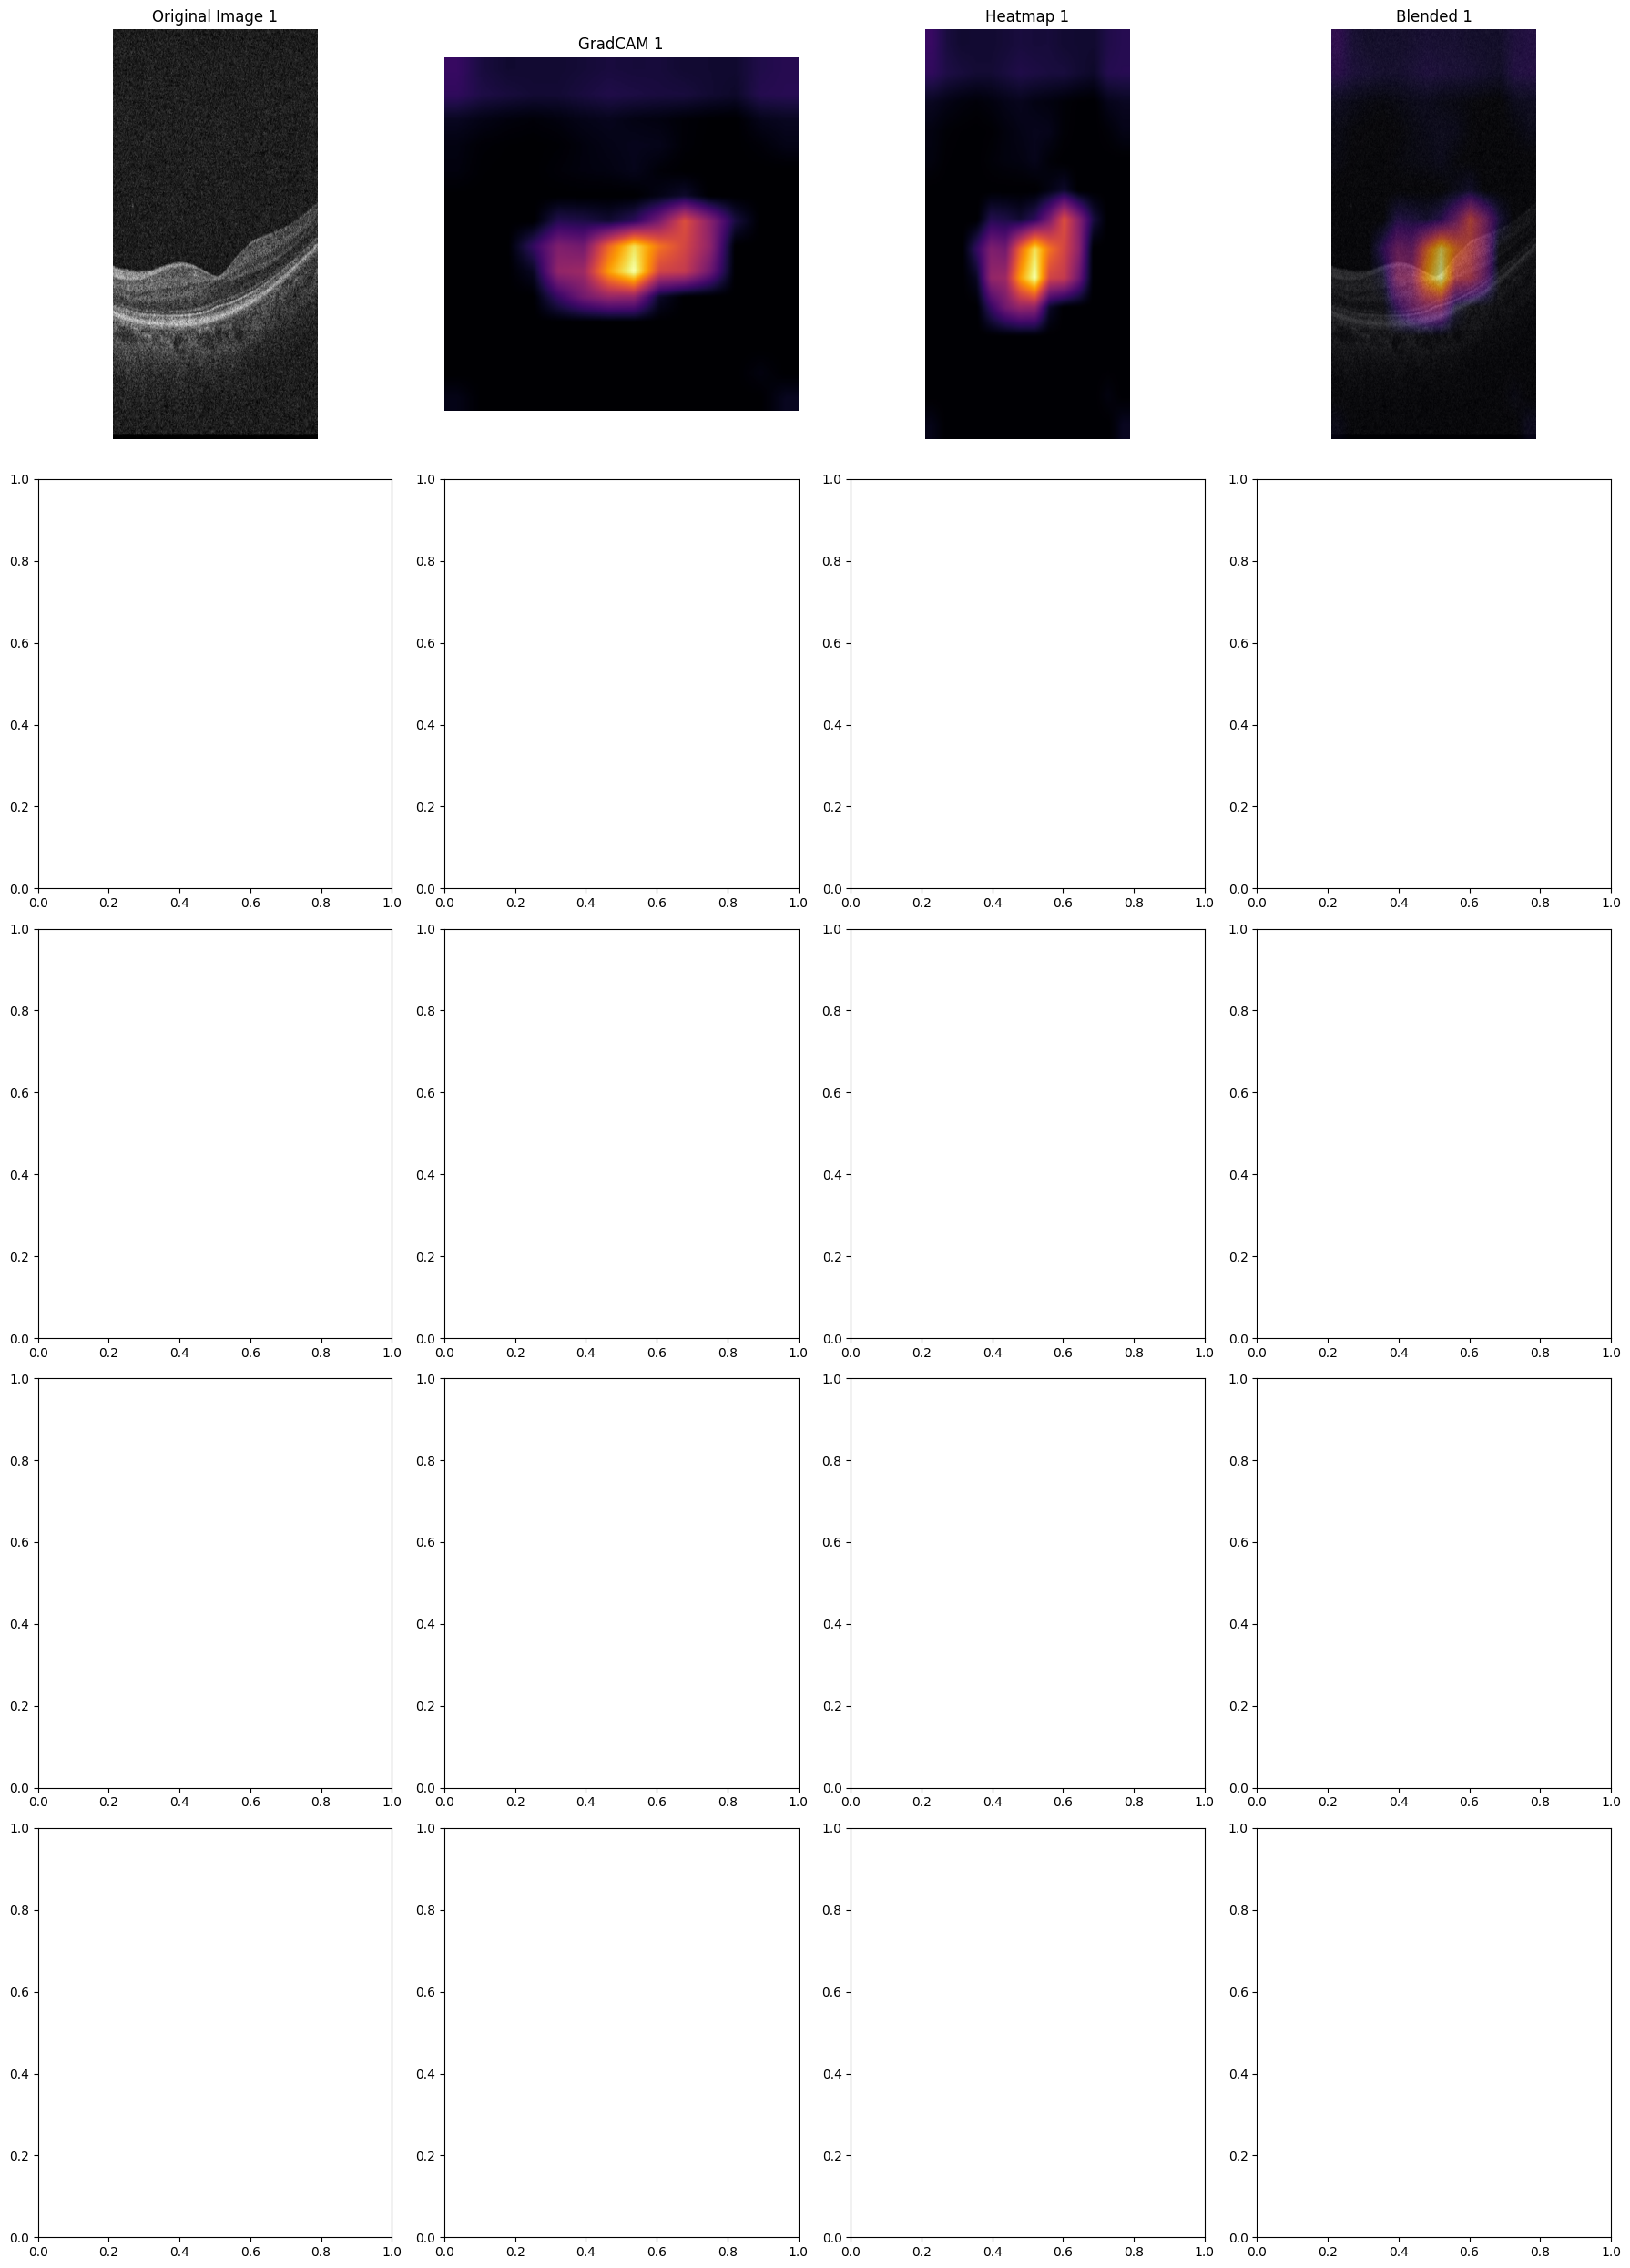

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import cv2

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# === Step 1: Define model + device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "best_VGG_model_1.pth"
model = load_model(model_path, device)

# === Step 2: Define transform ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.22])])

all_image_paths = [
    r"C:\Users\micah\OneDrive\Gmail OneDrive\Desktop\CMU\_Spring 2025\Projects in BME\Fovea Detection\processed_volumes\1017\left\1017_left_bscan_061.png"
]

# === Step 4: Verify Grad-CAM works (optional debug tool) ===
def verify_gradcam_flow(model, device):
    test_input = torch.randn(1, 3, 224, 224).to(device)
    target_layer = model.vgg16.features[-1]
    gradcam = GradCAM(model, target_layer)
    output = gradcam.forward(test_input)
    output.backward()
    print(f"Output: {output.item():.4f}")
    print(f"Activations: {gradcam.activations.shape}")
    print(f"Gradients: {gradcam.gradients.shape}")
    del gradcam                         


class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits
    
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

import matplotlib.pyplot as plt
import cv2
import numpy as np


def visualize_multiple_gradcams(model, image_paths, device, transform, num_images=2):
    results = []
    
    for i, img_path in enumerate(image_paths[:num_images]):
        image, cam, heatmap, blended = visualize_gradcam(model, img_path, device, transform)
        results.append((image, cam, heatmap, blended))
    
    # Create figure with better layout
    fig, axes = plt.subplots(num_images, 4, figsize=(18, 5*num_images))
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    
    for i, (image, cam, heatmap, blended) in enumerate(results):
        # Original Image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Original Image {i+1}", fontsize=12)
        axes[i, 0].axis('off')
        
        # GradCAM
        axes[i, 1].imshow(cam, cmap='inferno')
        axes[i, 1].set_title(f"GradCAM {i+1}", fontsize=12)
        axes[i, 1].axis('off')
        
        # Heatmap
        axes[i, 2].imshow(heatmap)
        axes[i, 2].set_title(f"Heatmap {i+1}", fontsize=12)
        axes[i, 2].axis('off')
        
        # Blended
        axes[i, 3].imshow(blended)
        axes[i, 3].set_title(f"Blended {i+1}", fontsize=12)
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results
 
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # Forward hook
        def forward_hook(module, input, output):
            self.activations = output
            return None  # Important for some PyTorch versions
        
        # Backward hook
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
            return None  # Important for some PyTorch versions
        
        self.forward_hook = target_layer.register_forward_hook(forward_hook)
        self.backward_hook = target_layer.register_backward_hook(backward_hook)
    
    def __del__(self):
        self.forward_hook.remove()
        self.backward_hook.remove()
    
    def forward(self, x):
        return self.model(x)
    
    def generate_cam(self, x, target_class=None):
        # Forward pass
        output = self.forward(x)
        
        if target_class is None:
            target_class = 0 if torch.sigmoid(output).item() < 0.5 else 1
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass - CRITICAL FIX FOR BINARY CLASSIFICATION
        one_hot = torch.zeros_like(output)
        one_hot[0][0] = output  # Backprop through the actual output value
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Check if gradients were captured
        if self.gradients is None:
            raise RuntimeError("No gradients captured! Check hook registration.")
        
        # Pool gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Compute CAM
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, x.shape[2:], mode='bilinear', align_corners=False)
        
        # Detach and process
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam
def verify_gradcam_flow(model, device):
    # Create test input
    test_input = torch.randn(1, 3, 512, 1024).to(device)
    
    # Initialize GradCAM
    target_layer = model.vgg16.features[-1]
    gradcam = GradCAM(model, target_layer)
    
    # Forward pass
    output = gradcam.forward(test_input)
    print(f"Model output: {output.item():.4f}")
    
    # Backward pass
    output.backward()
    
    # Verify activations and gradients
    print(f"Activations shape: {gradcam.activations.shape if gradcam.activations is not None else 'None'}")
    print(f"Gradients shape: {gradcam.gradients.shape if gradcam.gradients is not None else 'None'}")
    print(f"Gradients mean: {gradcam.gradients.mean().item() if gradcam.gradients is not None else 'None'}")
    
    del gradcam
def find_best_target_layer(model):
    # Try different layers
    candidate_layers = [
        model.vgg16.features[24],  # Last conv before pooling
        model.vgg16.features[17],  # Middle conv
        model.vgg16.features[10]   # Early conv
    ]
    
    for i, layer in enumerate(candidate_layers):
        print(f"\nTesting layer {i}:")
        verify_gradcam_flow(model, device)
def visualize_gradcam(model, image_path, device, transform):
    # Load image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Try multiple target layers if first fails
    target_layers = [
        model.vgg16.features[-1],  # Default last layer
        model.vgg16.features[24],  # Last conv before pooling
        model.vgg16.features[17]   # Middle conv layer
    ]
    
    for i, layer in enumerate(target_layers):
        print(f"\nAttempting with target layer {i}")
        gradcam = GradCAM(model, layer)
        try:
            cam = gradcam.generate_cam(input_tensor)
            if cam.max() > 0.1:  # Only accept meaningful CAMs
                print(f"Valid CAM found with layer {i}")
                break
        except Exception as e:
            print(f"Layer {i} failed: {str(e)}")
        del gradcam
    
    # Generate visualizations
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_INFERNO)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, image.size)
    
    # Create blended image
    image_np = np.array(image)
    blended = cv2.addWeighted(image_np, 0.3, heatmap, 0.7, 0)
    
    return image, cam, heatmap, blended
verify_gradcam_flow(model, device)

results = visualize_multiple_gradcams(model, all_image_paths, device, transform, num_images=5)


In [9]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# === Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Image path ===
image_path = r"C:\Users\micah\OneDrive\Gmail OneDrive\Desktop\CMU\_Spring 2025\Projects in BME\Fovea Detection\processed_volumes\1017\left\1017_left_bscan_061.png"
output_path = "gradcam_blended.png"

# === Preprocess ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
image_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(image_pil).unsqueeze(0).to(device)

# === Compute Grad-CAM ===
target_layer = model.vgg16.features[24]
gradcam = GradCAM(model, target_layer)
cam = gradcam.generate_cam(input_tensor)

# === Prepare blended image ===
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_INFERNO)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, image_pil.size)

image_np = np.array(image_pil)
blended = cv2.addWeighted(image_np, 0.3, heatmap, 0.7, 0)

# === Save without padding ===
fig = plt.figure(frameon=False)
fig.set_size_inches(blended.shape[1] / 100, blended.shape[0] / 100)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(blended)
fig.savefig(output_path, dpi=100, bbox_inches='tight', pad_inches=0)
plt.close(fig)

print(f"✅ Saved blended Grad-CAM to: {output_path}")


✅ Saved blended Grad-CAM to: gradcam_blended.png


## GRADCAM++ Additions

In [10]:
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook the activations and gradients
        self.forward_hook = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = self.target_layer.register_backward_hook(self.save_gradient)

    def __del__(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def generate_cam(self, input_tensor):
        output = self.forward(input_tensor)
        score = output[0][0]
        self.model.zero_grad()
        score.backward(retain_graph=True)

        grads = self.gradients
        acts = self.activations

        grads_power_2 = grads ** 2
        grads_power_3 = grads ** 3
        sum_acts = torch.sum(acts, dim=(2, 3), keepdim=True)
        eps = 1e-8

        alpha_num = grads_power_2
        alpha_denom = grads_power_2 * 2 + sum_acts * grads_power_3
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom) * eps)
        alpha = alpha_num / alpha_denom

        weights = (alpha * F.relu(grads)).sum(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [11]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def save_blended_gradcampp_image(image_path, cam, output_path="gradcampp_blended.png", colormap_name="inferno"):
    image_pil = Image.open(image_path).convert("RGB")
    image_np = np.array(image_pil)

    # Choose OpenCV colormap
    colormaps = {
        "inferno": cv2.COLORMAP_INFERNO,
        "jet": cv2.COLORMAP_JET,
        "cool": cv2.COLORMAP_COOL,
        "hot": cv2.COLORMAP_HOT
    }
    colormap = colormaps.get(colormap_name.lower(), cv2.COLORMAP_INFERNO)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, image_pil.size)

    blended = cv2.addWeighted(image_np, 0.3, heatmap, 0.7, 0)

    fig = plt.figure(frameon=False)
    fig.set_size_inches(blended.shape[1] / 100, blended.shape[0] / 100)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(blended)
    fig.savefig(output_path, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    print(f"✅ Grad-CAM++ saved to: {output_path}")


In [12]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# === Required paths ===
image_path = r"C:\Users\micah\OneDrive\Gmail OneDrive\Desktop\CMU\_Spring 2025\Projects in BME\Fovea Detection\processed_volumes\1017\left\1017_left_bscan_061.png"
# model_path = r"path\to\your_model.pth"  # update this if needed

# === Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = load_model(model_path, device)
# assume model is already loaded and ready to go.

# === Preprocess image ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
image_pil = Image.open(image_path).convert("RGB")
input_tensor = transform(image_pil).unsqueeze(0).to(device)

# === Run Grad-CAM++ ===
target_layer = model.vgg16.features[24]
gradcampp = GradCAMPlusPlus(model, target_layer)
cam_pp = gradcampp.generate_cam(input_tensor)

# === Save output ===
save_blended_gradcampp_image(
    image_path=image_path,
    cam=cam_pp,
    output_path="gradcampp_blended_jet.png",
    colormap_name="jet"
)

save_blended_gradcampp_image(
    image_path=image_path,
    cam=cam_pp,
    output_path="gradcampp_blended_inferno.png",
    colormap_name="inferno"
)



✅ Grad-CAM++ saved to: gradcampp_blended_jet.png
✅ Grad-CAM++ saved to: gradcampp_blended_inferno.png


# VANILLA TAKE 2 (BUG BE GONE)

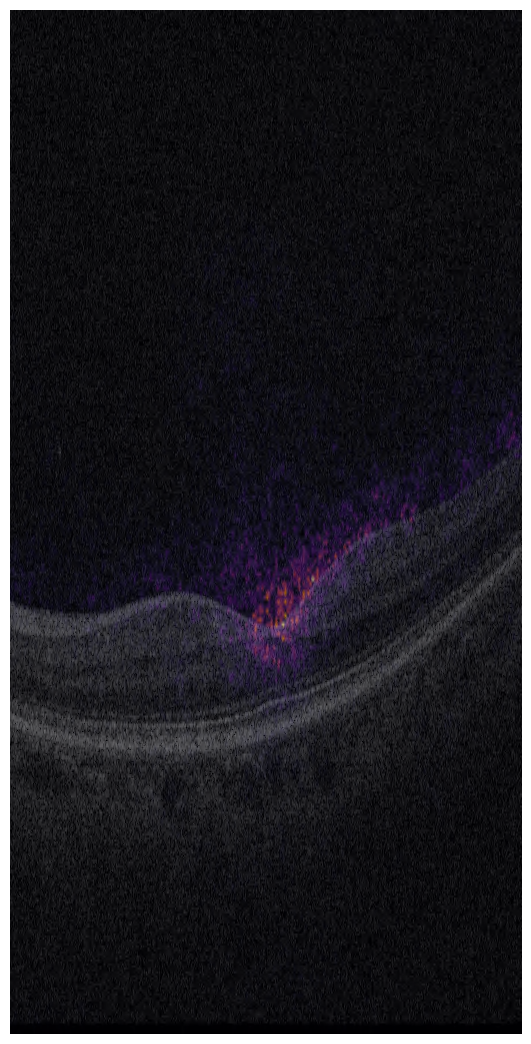

✅ Inferno saliency heatmap saved to: vanilla_saliency_inferno.png


In [15]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def visualize_inferno_saliency(image_pil, saliency, output_path="vanilla_heatmap_inferno.png", alpha=0.5):
    # Normalize saliency
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    saliency_uint8 = np.uint8(255 * saliency_norm)

    # Apply Inferno colormap
    heatmap = cv2.applyColorMap(saliency_uint8, cv2.COLORMAP_INFERNO)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, image_pil.size)

    # Original image
    image_rgb = np.array(image_pil.convert("RGB"))

    # Blend image with heatmap
    blended = cv2.addWeighted(image_rgb, 1 - alpha, heatmap, alpha, 0)

    # Display with no padding
    fig = plt.figure(frameon=False)
    fig.set_size_inches(blended.shape[1] / 100, blended.shape[0] / 100)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(blended)
    plt.show()

    # Save result
    plt.imsave(output_path, blended)
    print(f"✅ Inferno saliency heatmap saved to: {output_path}")

# === Load image and preprocess ===
image_path = r"C:\Users\micah\OneDrive\Gmail OneDrive\Desktop\CMU\_Spring 2025\Projects in BME\Fovea Detection\processed_volumes\1017\left\1017_left_bscan_061.png"
image_pil = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
input_tensor = transform(image_pil).unsqueeze(0).to(device)
input_tensor.requires_grad_()  # Enable gradient tracking

# === Forward and backward ===
output = model(input_tensor)
score = output[0][0]  # raw logit
model.zero_grad()
score.backward()

# === Compute vanilla saliency (gradients w.r.t input) ===
saliency = input_tensor.grad.data.abs().squeeze().cpu().numpy()
saliency = np.max(saliency, axis=0)  # Take max across channels

# === Visualize and save ===
visualize_inferno_saliency(
    image_pil=image_pil,
    saliency=saliency,
    output_path="vanilla_saliency_inferno.png",
    alpha=0.6
)
